# Toric Decoder
Apply the [2D decoder](https://arxiv.org/abs/1406.2338), followed by [minimum-weight perfect matching](https://arxiv.org/abs/2303.15933), on the toric code with side length $L$. We consider i.i.d. $X$ errors on the qubits (bonds), and work with $m$ anyons (plaquettes). The errors are plotted on the dual lattice by default.
## 2D Decoder
At each time step out of $T=L$ total, perform the following steps:
1. Make an $X$ error on each qubit with probability $p=0.05$.
2. Perform $c$ field updates, according to the following rule:$$\phi\mapsto\phi+\frac\eta4\nabla^2\phi+q$$Where $\phi$ is the auxillary field, $\eta=0.1$ is the Jacobi smoothing parameter, and $q$ is the anyon density with unit mass $-\frac4\eta$. Take $4\pi G=1$, so that $\nabla^2\phi=\rho$.
3. For each anyon, move it its highest-$\phi$ neighboring cell with probability $\frac12$.

In [1]:
import numpy as np
import cupy as cp
from tqdm.notebook import tqdm

from toric import State, pcm, mwpm, logical_error
from toric import decoder_2D, decoder_2D_density
from pymatching import Matching

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150

In [2]:
# Simulation parameters

N = 5000 # Shots
L = 100 # Lattice size
p_error = 0.004 # Error probability per spin
η = 0.1 # Smoothing paramter for Jacobi method
c = 16 # "Field velocity" - number of field updates per cycle
T = L # Epochs

matching = Matching(pcm(L))

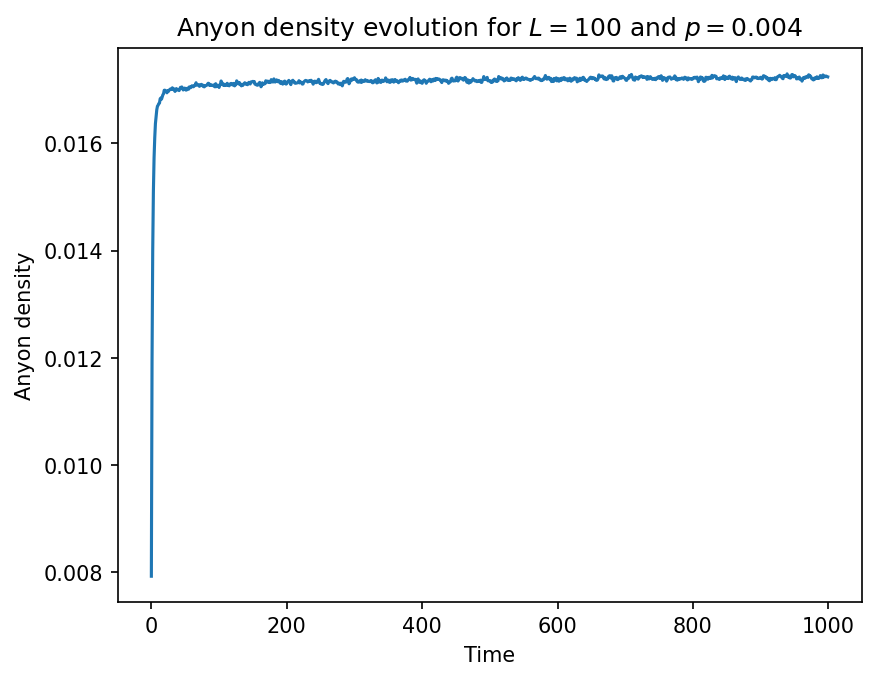

In [3]:
state = State(N, L)
density = decoder_2D_density(state, 10*T, c, η, p_error)
t = np.arange(10*T)
plt.clf()
plt.plot(density)
errors = np.sqrt(density * (1 - density) / N) / L
plt.fill_between(t, density - errors, density + errors, alpha=0.5)
plt.ylabel("Anyon density")
plt.xlabel("Time")
plt.title(f"Anyon density evolution for $L={L}$ and $p={p_error}$")
plt.show()

In [14]:
p_errors = np.linspace(0.004,0.005,10)
fails = np.empty_like(p_errors)
for i, p_error in enumerate(tqdm(p_errors)):
    state = State(N, L)
    decoder_2D(state, T, c, η, p_error)
    x_correction, y_correction = mwpm(matching, state.q)
    fails[i] = np.mean(logical_error(state.x_error.get() ^ x_correction, state.y_error.get() ^ y_correction))

  0%|          | 0/10 [00:00<?, ?it/s]

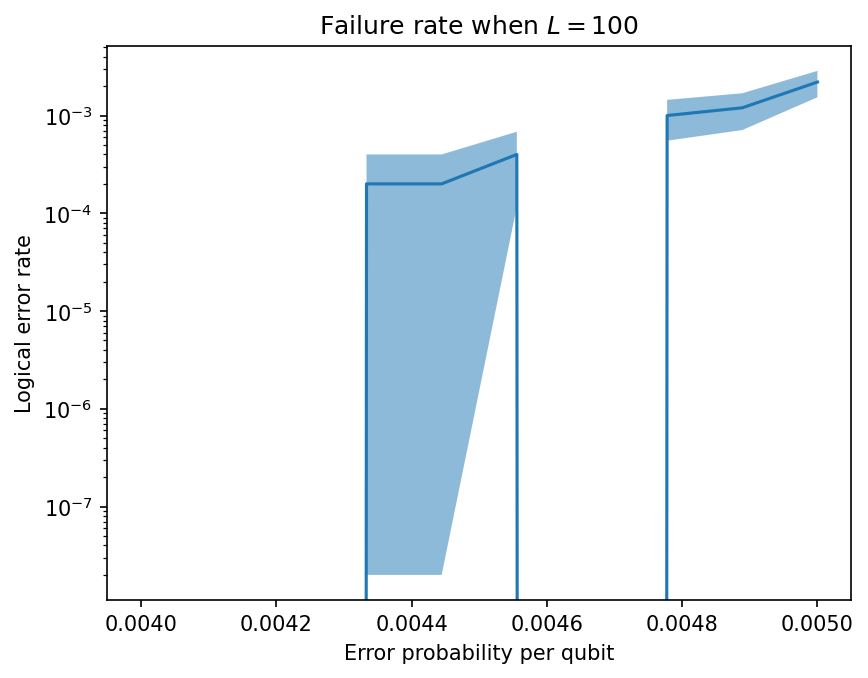

In [15]:
plt.clf()
errors = np.sqrt(fails * (1 - fails) / N)
plt.plot(p_errors, fails)
plt.fill_between(p_errors, fails - errors, fails + errors, alpha = 0.5)
# plt.xscale('log')
plt.yscale('log')
plt.xlabel("Error probability per qubit")
plt.ylabel("Logical error rate")
plt.title(f"Failure rate when $L={L}$")
plt.show()